### Load libraries

In [1]:
# systemic libraries
import os 
import sys
import tempfile
import warnings
from datetime import date
import math

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy
import decoupler

# visualization
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
with open("/image_version", "r") as f:
    image_name = f.readline().replace("\n", "")
image_name

'sddcunit/downstream:sc-1.1.0'

### Load the data

In [4]:
# Load the individual datasets to extract sample_id information
#adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad")

### Data integration

In [5]:
# Define paths
#adata_file = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony"
#harmony_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony/integration_script.py"
#sbatch_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony/run_integration.job"

In [6]:
# Write the integration script 
#integration_script = f"""
#import os 
#import sys
#import tempfile
#import warnings
#from datetime import date
#
# single-cell and data-wrangling 
#import scanpy as sc 
#import pandas as pd 
#import numpy as np 
#import numba as nb
#import anndata as ad
#import leidenalg
#import scanpy.external as sce
#import harmonypy
#
# Load the d|ata
#adata_name = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad"
#adata = sc.read_h5ad(adata_name)
#
# Select the layer
#adata.X = adata.layers['log_normalized_scaled_counts'].copy()
#
# Calculate the PCA 
#sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 80)
#
# Run harmony
#sce.pp.harmony_integrate(adata, key = 'dataset_of_origin', adjusted_basis='X_pca_harmony',
#                         max_iter_harmony = 30)
#
# Save the data
#adata.write_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated_harmony.h5ad")
#
#"""
#with open(harmony_script_path, "w") as f:
#    f.write(integration_script)

In [7]:
# Write the bash script
#sbatch_script = f"""#!/bin/bash
##SBATCH --time=24:00:00
##SBATCH --nodes=1
##SBATCH --ntasks-per-node=1
##SBATCH --gres=gpu:1
##SBATCH --partition=gpuq
##SBATCH --job-name=integration
##SBATCH --mem=64GB
##SBATCH --mail-type=END
##SBATCH --output=%x_%j.log
#
#export SINGULARITY_CACHEDIR=/group/kalebic/Nikola/1_single_cell_final/Nikola_final/scmorpho/.singularity/
#export SINGULARITY_TMPDIR=$TMPDIR
#
#module load cuda11.1/toolkit/11.1.1
#module load singularity
#singularity exec --nv -H {home_path} \\
#                 docker://{image_name} \\
#                 python3 {os.path.abspath(harmony_script_path)}
#
#"""
#
#with open(sbatch_script_path, "w") as f:   
#    f.write(sbatch_script)

### Neighboring

In [8]:
# Load the integrated data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated_harmony.h5ad")

In [9]:
# Compute the kNN graph
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=80, random_state = 111)

2025-06-05 00:03:56.829849: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 00:03:56.832928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 00:03:56.865181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 00:03:56.865205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 00:03:56.865229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [10]:
# Compute the UMAP
sc.tl.umap(adata, random_state = 111)

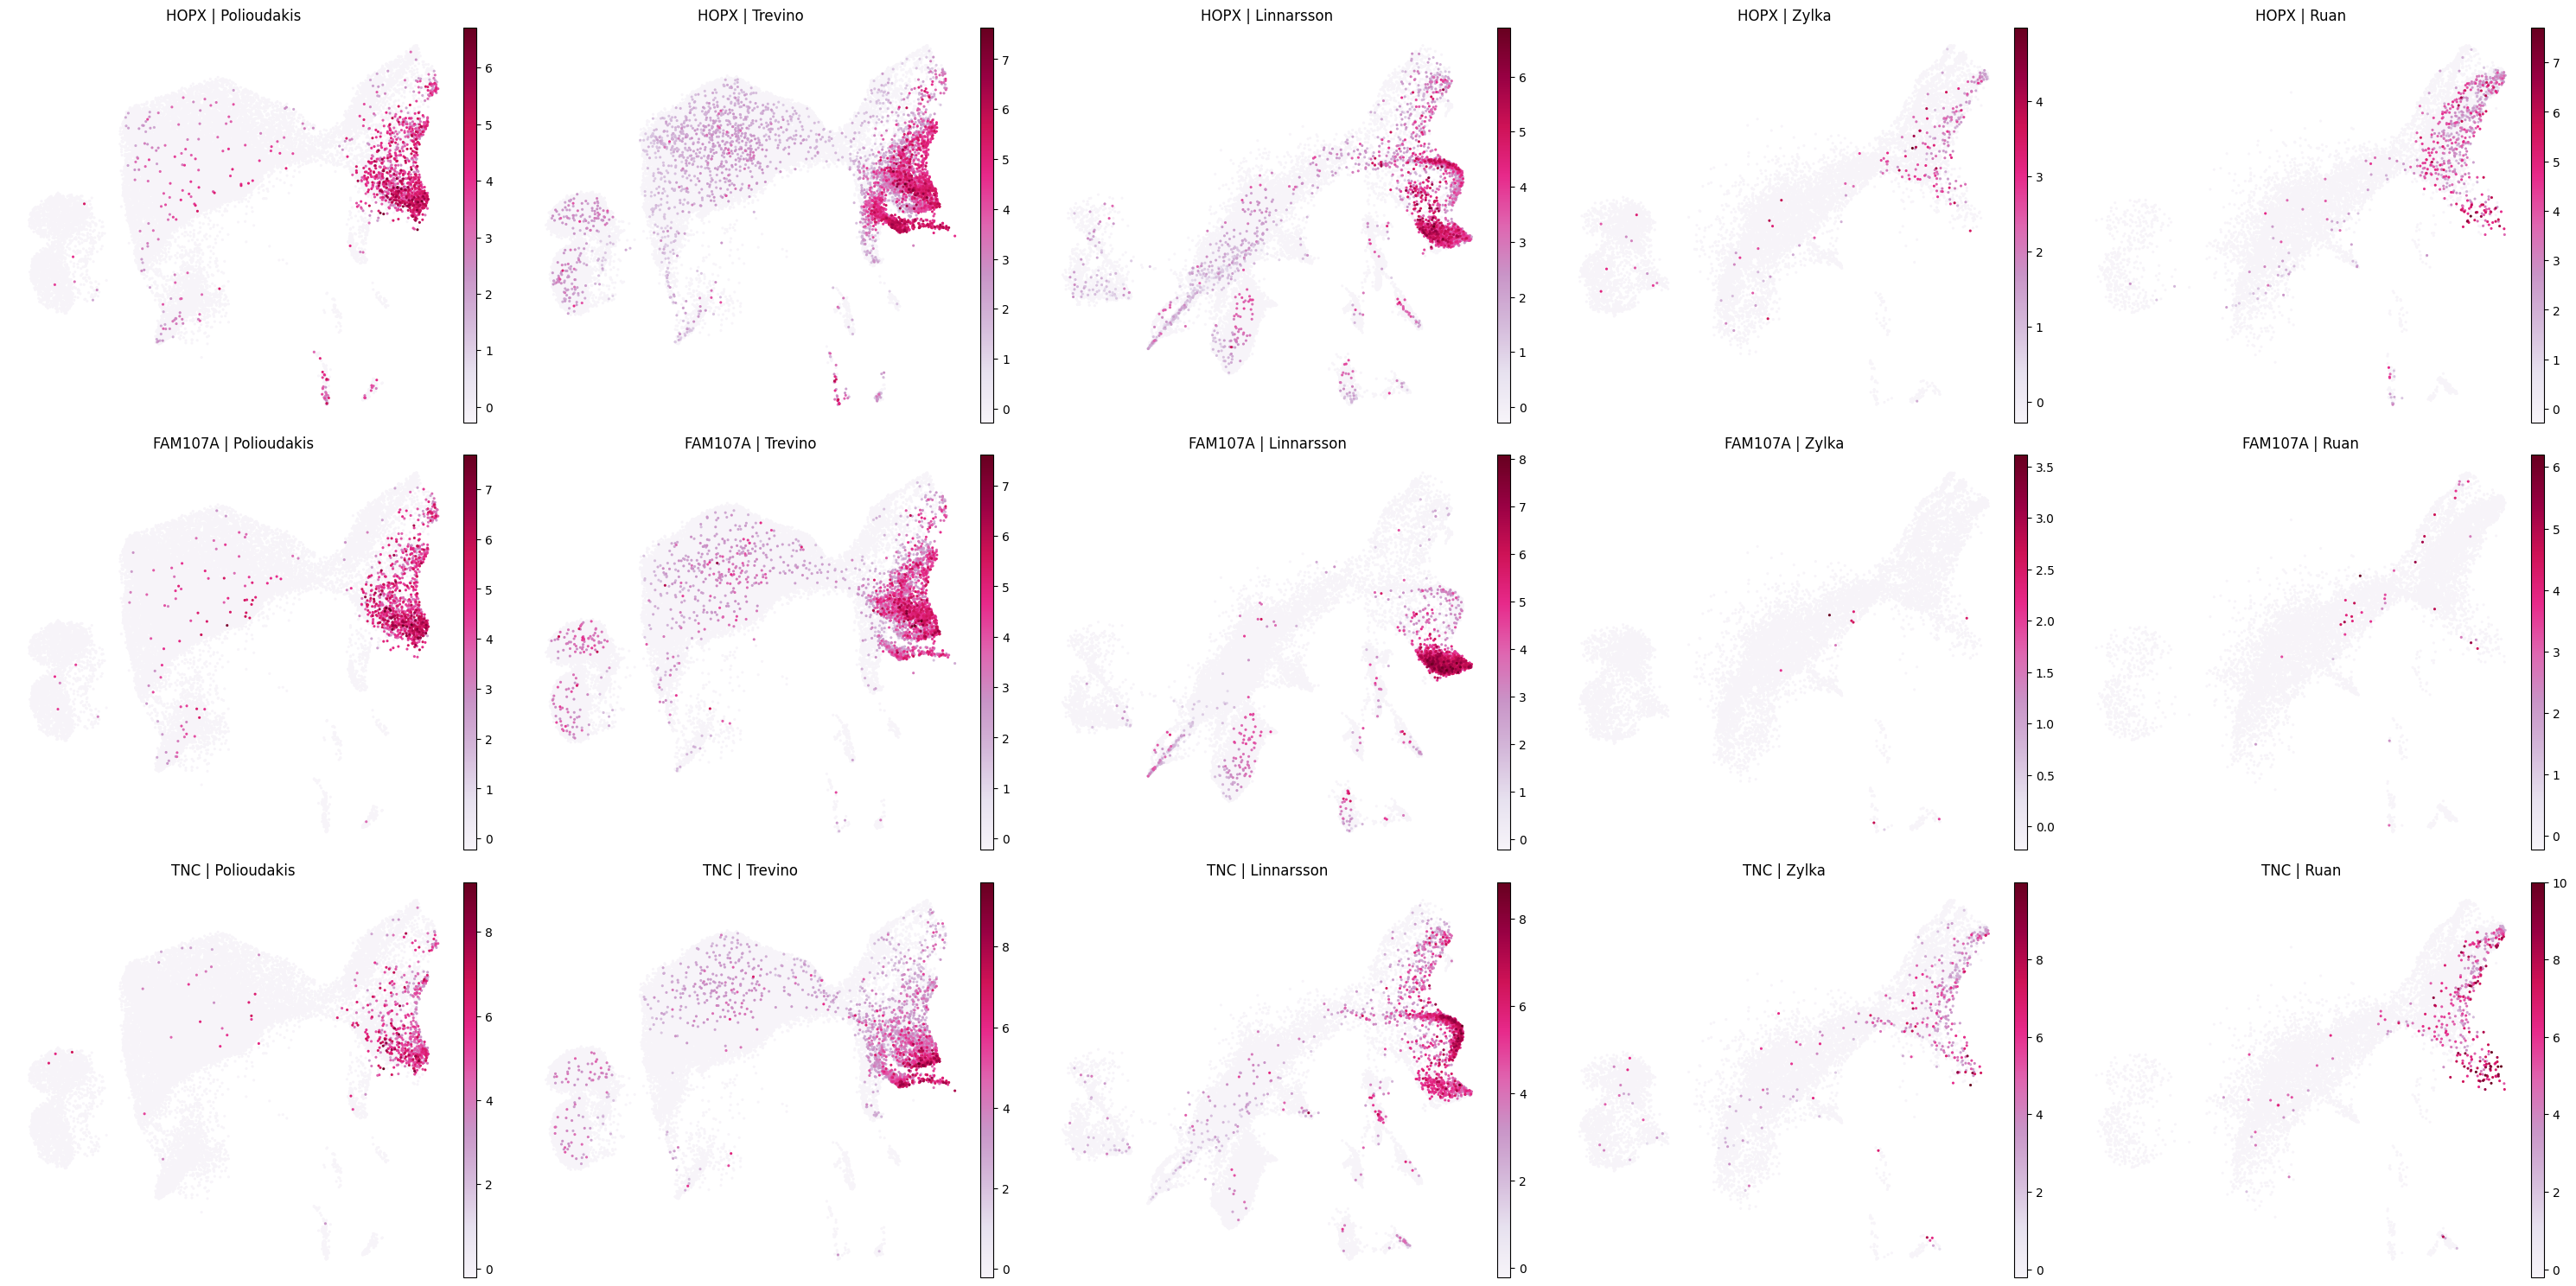

In [11]:
import matplotlib.pyplot as plt
# List genes of interest
genes = ['HOPX', 'FAM107A', 'TNC']

# Define the subplots
fig, axes = plt.subplots(len(genes), len(adata.obs['dataset_of_origin'].unique()), figsize = (6*len(adata.obs['dataset_of_origin'].unique()), 5*len(genes)))
axes = axes.flatten()

# Plot gene expression across datasets
sp_index = 0
for r_idx, gene in enumerate(genes):
    for d_idx, dataset in enumerate(adata.obs['dataset_of_origin'].unique()):
        ax = axes[sp_index]
        sc.pl.umap(
            adata[adata.obs['dataset_of_origin'] == dataset], 
            color = gene, 
            ax = ax, 
            show = False, 
            size = 20, 
            frameon = False, 
            legend_loc = 'on_data', 
            legend_fontsize = 10, 
            cmap = 'PuRd'
        )
        ax.set_title(f"{gene} | {dataset}")
        sp_index += 1

plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_hNcx_mDG_mNcx_integrated_bRG_marker_expression.pdf', 
            dpi = 300, bbox_inches = 'tight')
plt.show() 

### Clustering

In [12]:
# Compute the leiden clustering at low-resolution (per species)
sc.tl.leiden(adata, key_added="X_leiden_harmony", resolution=0.40, random_state = 111)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_2853878/1345915404.py:19: UserWarning: T

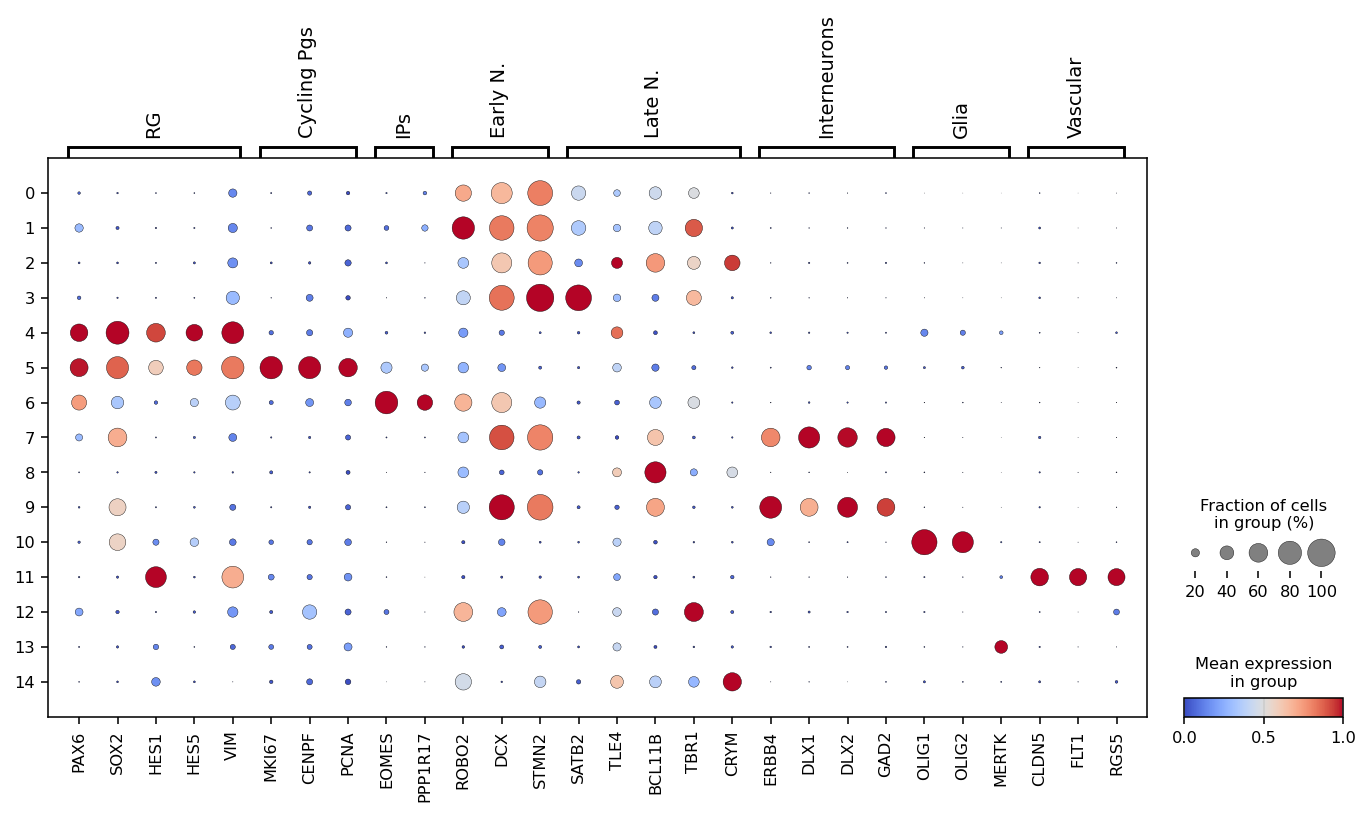

In [13]:
# Plot the expression of marker genes across clusters
sc.set_figure_params(dpi = 70, dpi_save = 300, fontsize = 10)

# Define marker genes for the annotation
markers = {'RG': ['PAX6', 'SOX2', 'HES1', 'HES5', 'VIM'], 
           'Cycling Pgs': ['MKI67', 'CENPF', 'PCNA'],
           'IPs' : ['EOMES', 'PPP1R17'], 
           'Early N.' : ['ROBO2', 'DCX', 'STMN2'],
           'Late N.' : ['SATB2','TLE4', 'BCL11B', 'TBR1', 'CRYM'],
           'Interneurons' : ['ERBB4', 'DLX1', 'DLX2', 'GAD2'],
           'Glia' : ['OLIG1', 'OLIG2', 'MERTK'],
           'Vascular': ['CLDN5', 'FLT1', 'RGS5'], 
          }

# Plot the dotplot
sc.pl.dotplot(adata, markers, groupby ='X_leiden_harmony', mean_only_expressed = False, 
              show = False, standard_scale = 'var', cmap = 'coolwarm')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_2853878/390132885.py:15: UserWarning: Th

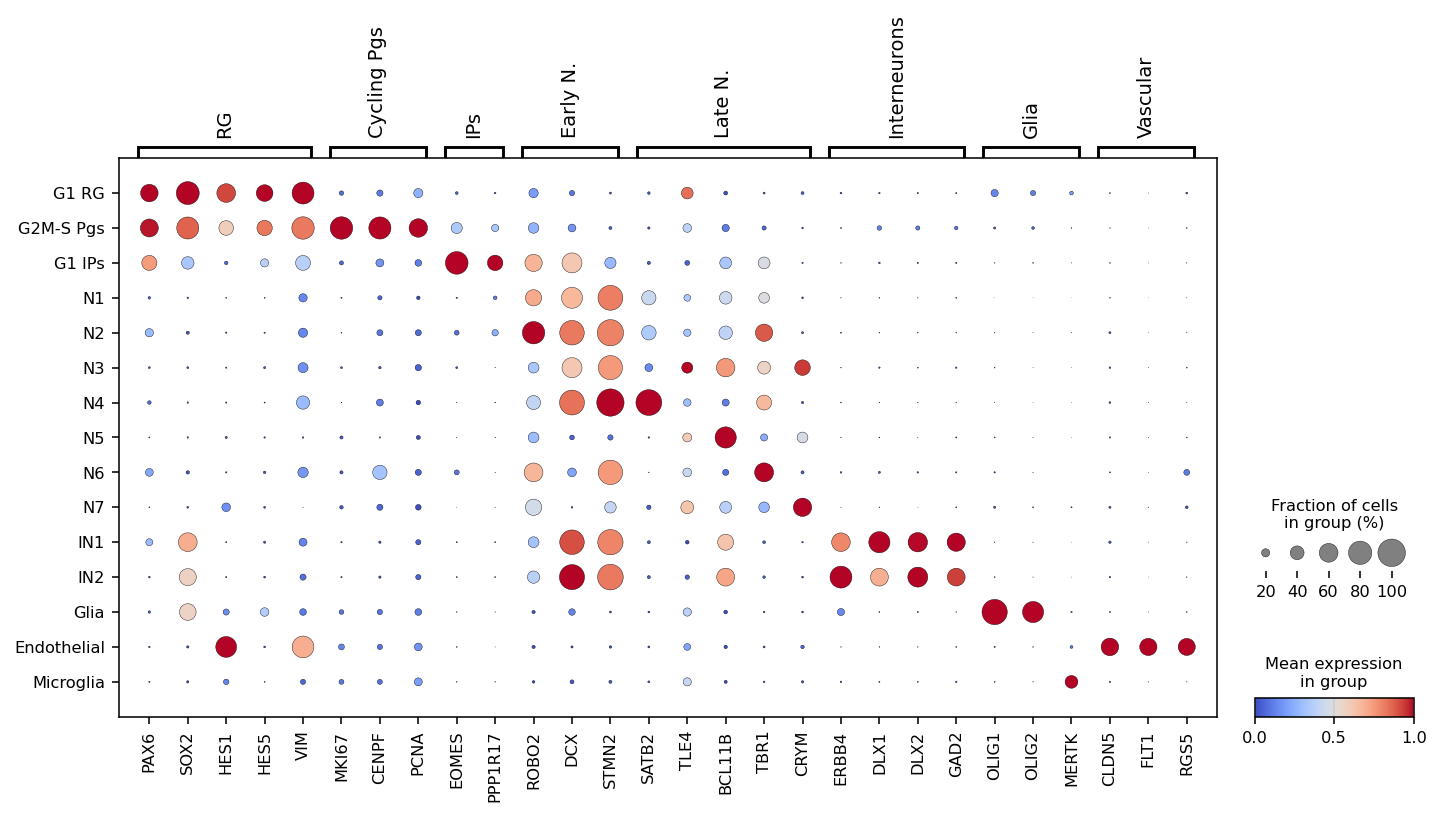

In [14]:
# Rename the clusters
new_cluster_names = ['N1', 'N2', 'N3', 'N4', 'G1 RG', 'G2M-S Pgs', 'G1 IPs', 'IN1', 'N5', 'IN2', 'Glia', 
                     'Endothelial', 'N6', 'Microglia', 'N7']

adata.rename_categories('X_leiden_harmony', new_cluster_names)

# Re-order clusters
adata.obs['X_leiden_harmony'] = pd.Categorical(adata.obs['X_leiden_harmony'], categories = ['G1 RG', 'G2M-S Pgs', 'G1 IPs', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
                                                                                            'IN1', 'IN2', 'Glia', 'Endothelial', 'Microglia'], ordered = True)

# Plot the dotplot
sc.pl.dotplot(adata, markers, groupby ='X_leiden_harmony', mean_only_expressed = False, 
              show = False, standard_scale = 'var', cmap = 'coolwarm')

plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_integrated_leiden_clusters.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


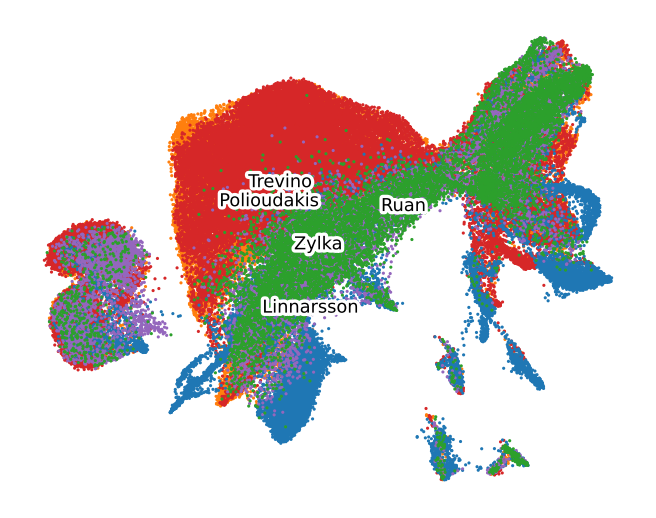

In [15]:
# Plot the UMAP (all datasets together)
sc.set_figure_params(figsize=(5, 4))
ax = sc.pl.umap(adata, color=["dataset_of_origin"],frameon=False, show = False, legend_fontsize=8, size =8,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_dataset_of_origin.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting

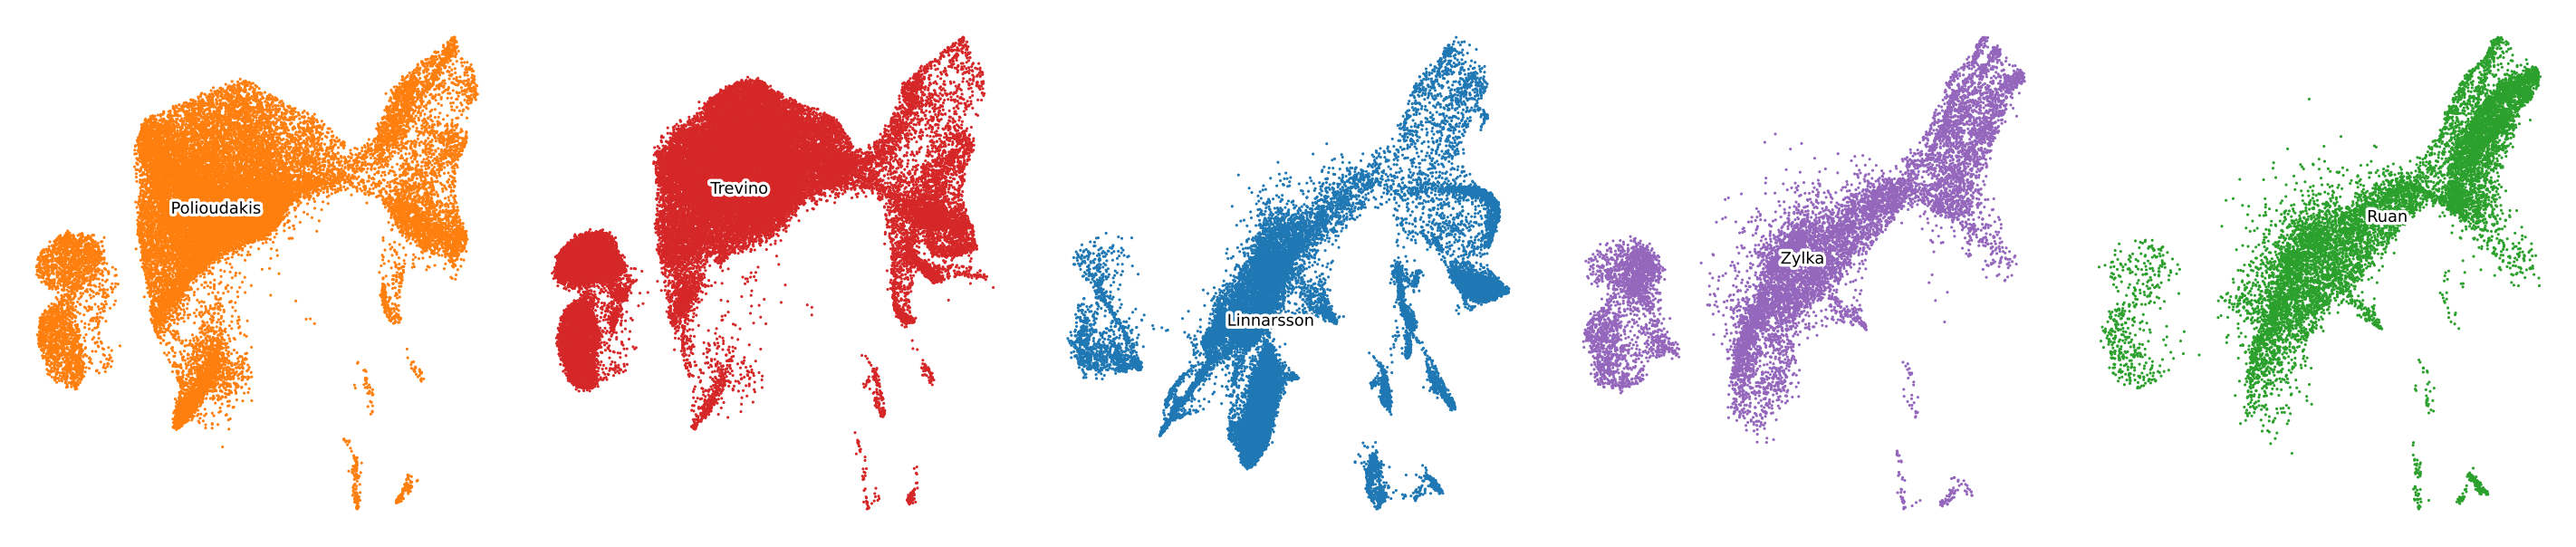

In [16]:
# Plot the UMAP (all datasets separately)
sc.set_figure_params(figsize=(5, 4))

fig, axes = plt.subplots(1, 5, figsize = (18, 4))
axes = axes.flatten()

index = 0

for idx, dataset in enumerate(adata.obs['dataset_of_origin'].unique()):
    ax = axes[index]

    sc.pl.umap(adata[adata.obs['dataset_of_origin'] == dataset], 
               color=["dataset_of_origin"], 
               frameon=False, 
               show = False, 
               legend_fontsize=8, size =8,
               legend_loc = 'on data', 
               legend_fontweight=3, ncols = 1, 
               legend_fontoutline = 3, 
               title = '', 
               ax = ax)
    index += 1

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_dataset_of_origin_separate.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


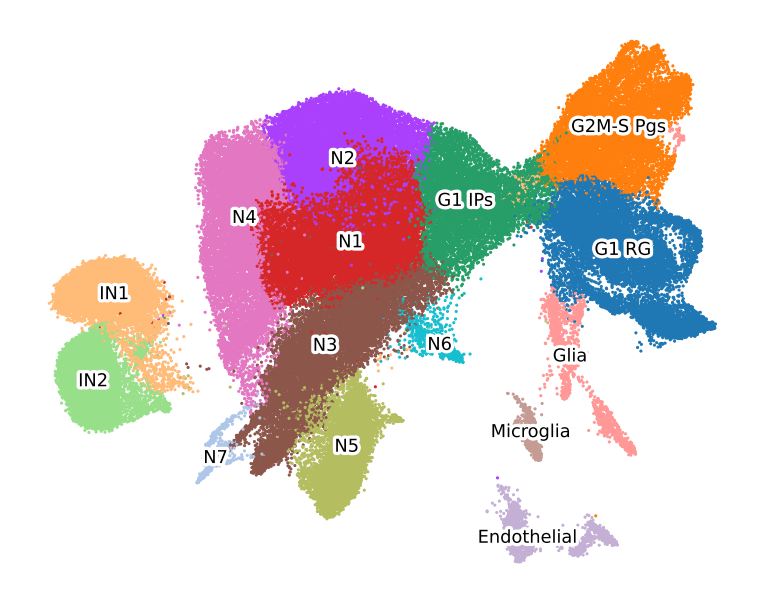

In [17]:
# Plot the UMAP
sc.set_figure_params(figsize=(5, 4))
ax = sc.pl.umap(adata, color=["X_leiden_harmony"],frameon=False, show = False, legend_fontsize=8, size =8,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.tight_layout()

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_clusters.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

### Subclustering

In [18]:
# Define the species column 
adata.obs['species'] = adata.obs['dataset_of_origin'].map({
    'Polioudakis': 'human_ncx',
    'Trevino': 'human_ncx', 
    'Linnarsson': 'mouse_dg', 
    'Zylka': 'mouse_ncx', 
    'Ruan': 'mouse_ncx'
})

In [19]:
# Subset G1 RG per species
## Human Ncx
adata_RG_hs_ncx = adata[(adata.obs['species'] == 'human_ncx') & (adata.obs['X_leiden_harmony'] == 'G1 RG')].copy()
## Mouse Ncx 
adata_RG_mm_ncx = adata[(adata.obs['species'] == 'mouse_ncx') & (adata.obs['X_leiden_harmony'] == 'G1 RG')].copy()
## Mouse DG
adata_RG_mm_dg = adata[(adata.obs['species'] == 'mouse_dg') & (adata.obs['X_leiden_harmony'] == 'G1 RG')].copy()

In [20]:
# Print the number of cells 
print("Number of cells in the human Ncx RG:", adata_RG_hs_ncx.shape[0])
print("Number of cells in the mouse DG RG:", adata_RG_mm_dg.shape[0])
print("Number of cells in the mouse Ncx RG:", adata_RG_mm_ncx.shape[0])

Number of cells in the human Ncx RG: 5340
Number of cells in the mouse DG RG: 3914
Number of cells in the mouse Ncx RG: 1970


In [21]:
%run -i '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/helper_functions/round_to_nearest.py'

adatas = {
    "human_neocortex" : adata_RG_hs_ncx, 
    "mouse_dentate_gyrus": adata_RG_mm_dg, 
    "mouse_neocortex": adata_RG_mm_ncx
}

for name, ad in adatas.items():
    ad_copy = ad.copy()
    cell_number = ad_copy.shape[0]
    original_number = cell_number*0.01
    rounded_number = round_to_nearest_number(original_number, basis = 5)
    print(f"For {name} dataset: | original number for is: {original_number} | rounded number is: {rounded_number}")

For human_neocortex dataset: | original number for is: 53.4 | rounded number is: 55
For mouse_dentate_gyrus dataset: | original number for is: 39.14 | rounded number is: 40
For mouse_neocortex dataset: | original number for is: 19.7 | rounded number is: 20


In [22]:
# Re-compute nearest neighbors (with the integrated PCA space)
sc.pp.neighbors(adata_RG_hs_ncx, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=55, random_state = 111)
sc.pp.neighbors(adata_RG_mm_dg, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=40, random_state = 111)
sc.pp.neighbors(adata_RG_mm_ncx, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=20, random_state = 111)

Number of cells per subcluster: leiden_subclustered_G1 RG
RG 1    2596
RG 2    1723
RG 3    1021
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


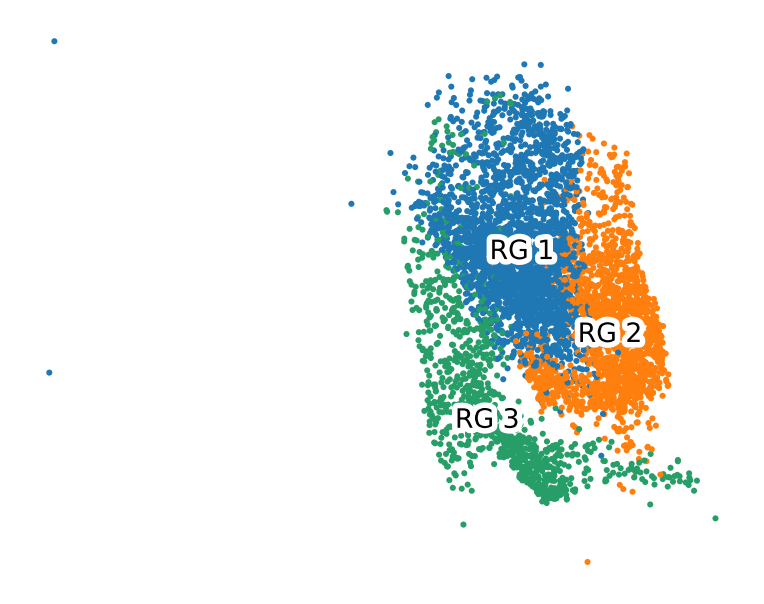

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_2853878/2756633999.py:26: UserWarning: T

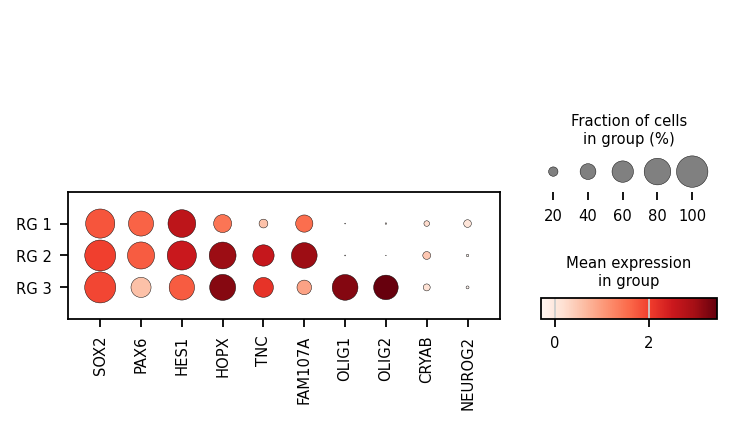

In [23]:
# Subcluster human Ncx 
clusters = ['G1 RG']
for cluster in clusters:
    sc.tl.leiden(adata_RG_hs_ncx, resolution=0.20, key_added=f'leiden_subclustered_{cluster}', restrict_to=('X_leiden_harmony', [cluster]),  random_state=111)

# Rename clusters
reannot = ['RG 1', 'RG 2', 'RG 3']
adata_RG_hs_ncx.rename_categories('leiden_subclustered_G1 RG', reannot)

# Print number of cells per each subcluster
print("Number of cells per subcluster:", adata_RG_hs_ncx.obs['leiden_subclustered_G1 RG'].value_counts())

# Plot clusters 
sc.set_figure_params(figsize=(5, 4))
sc.pl.umap(adata_RG_hs_ncx, color=["leiden_subclustered_G1 RG"],frameon=False, show = False, legend_fontsize=12, size =30,
           legend_loc = 'on data', legend_fontweight=4, ncols = 1, legend_fontoutline = 5, title = '')
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_RG_human_ncx_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Plot the dotplot
markers = ['SOX2', 'PAX6', 'HES1', 'HOPX', 'TNC', 'FAM107A', 'OLIG1', 'OLIG2', 'CRYAB', 'NEUROG2']
sc.set_figure_params(fontsize=8)
sc.pl.dotplot(adata_RG_hs_ncx, markers, groupby ='leiden_subclustered_G1 RG', 
              mean_only_expressed = False, show = False, cmap = 'Reds')
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_RG_human_ncx_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

Number of cells per subcluster: leiden_subclustered_G1 RG
G1 RG,0    2308
G1 RG,1    1606
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


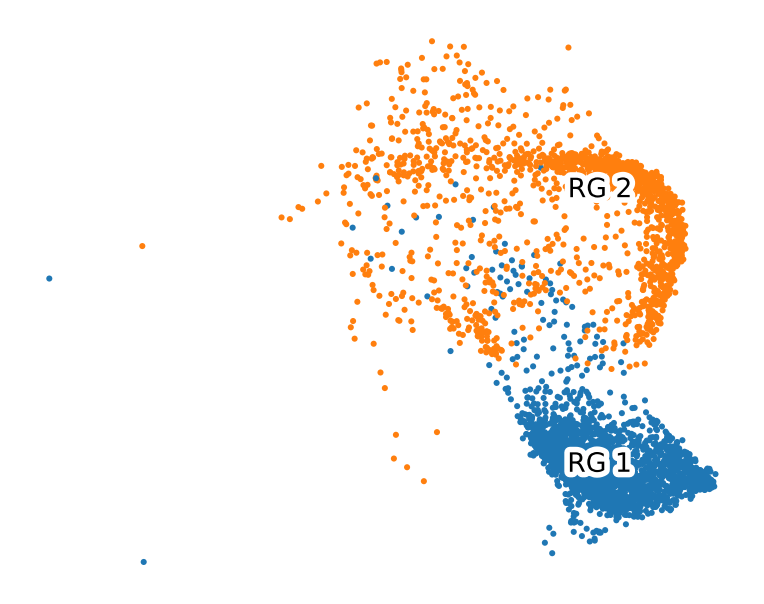

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_2853878/1165098708.py:28: UserWarning: T

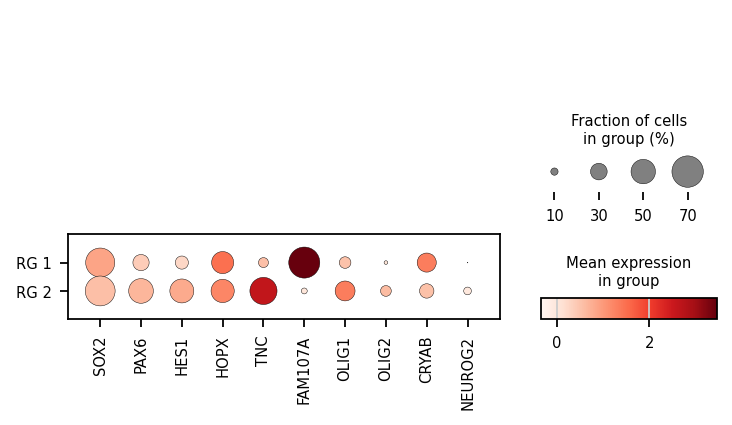

In [24]:
# Subcluster Mouse DG 
clusters = ['G1 RG']
for cluster in clusters:
    sc.tl.leiden(adata_RG_mm_dg, resolution=0.15, key_added=f'leiden_subclustered_{cluster}', restrict_to=('X_leiden_harmony', [cluster]),  random_state=111)


# Print number of cells per each subcluster
print("Number of cells per subcluster:", adata_RG_mm_dg.obs['leiden_subclustered_G1 RG'].value_counts())

# Rename clusters
reannot = ['RG 1', 'RG 2']
adata_RG_mm_dg.rename_categories('leiden_subclustered_G1 RG', reannot)

# Plot clusters 
sc.set_figure_params(figsize=(5, 4))
sc.pl.umap(adata_RG_mm_dg, color=["leiden_subclustered_G1 RG"],frameon=False, show = False, legend_fontsize=12, size =30,
           legend_loc = 'on data', legend_fontweight=4, ncols = 1, legend_fontoutline = 5, title = '')
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_RG_mouse_dg_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Plot the dotplot
markers = ['SOX2', 'PAX6', 'HES1', 'HOPX', 'TNC', 'FAM107A', 'OLIG1', 'OLIG2', 'CRYAB', 'NEUROG2']
sc.set_figure_params(fontsize=8)
sc.pl.dotplot(adata_RG_mm_dg, markers, groupby ='leiden_subclustered_G1 RG', 
              mean_only_expressed = False, show = False, cmap = 'Reds')

plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_RG_mouse_dg_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

Number of cells per subcluster: leiden_subclustered_G1 RG
G1 RG,0    1970
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


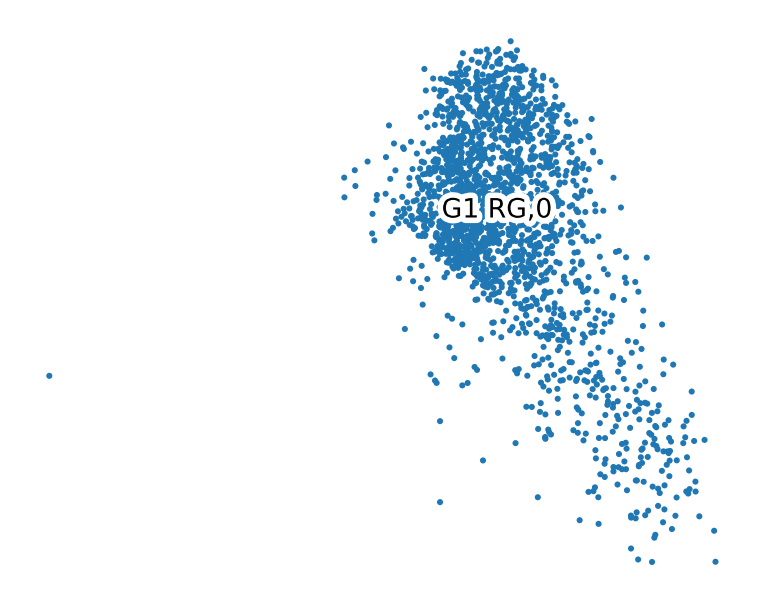

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/tmp/ipykernel_2853878/3463098405.py:27: UserWarning: T

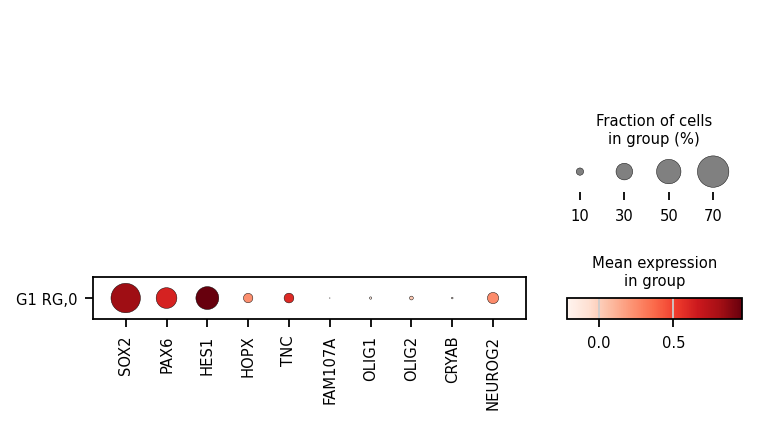

In [25]:
# Subcluster mouse Ncx 
clusters = ['G1 RG']
for cluster in clusters:
    sc.tl.leiden(adata_RG_mm_ncx, resolution=0.15, key_added=f'leiden_subclustered_{cluster}', restrict_to=('X_leiden_harmony', [cluster]),  random_state=111)

# Print number of cells per each subcluster
print("Number of cells per subcluster:", adata_RG_mm_ncx.obs['leiden_subclustered_G1 RG'].value_counts())

# Rename clusters
reannot = ['RG']
#adata_RG_mm_ncx.rename_categories('leiden_subclustered_G1 RG', reannot)

# Plot clusters 
sc.set_figure_params(figsize=(5, 4))
sc.pl.umap(adata_RG_mm_ncx, color=["leiden_subclustered_G1 RG"],frameon=False, show = False, legend_fontsize=12, size =30,
           legend_loc = 'on data', legend_fontweight=4, ncols = 1, legend_fontoutline = 5, title = '')
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_RG_mouse_ncx_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()


# Plot the dotplot
markers = ['SOX2', 'PAX6', 'HES1', 'HOPX', 'TNC', 'FAM107A', 'OLIG1', 'OLIG2', 'CRYAB', 'NEUROG2']
sc.set_figure_params(fontsize=8)
sc.pl.dotplot(adata_RG_mm_ncx, markers, groupby ='leiden_subclustered_G1 RG', 
              mean_only_expressed = False, show = False, cmap = 'Reds')
plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_RG_mouse_ncx_subsets.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

### Map subclusters to the dataset

In [26]:
# Define the empty .obs category
adata.obs['leiden_subclustered_G1_RG_ss'] = ""
# Map the human ncx RG to the full dataset
adata.obs.loc[adata_RG_hs_ncx.obs_names, 'leiden_subclustered_G1_RG_ss'] = 'human_ncx_' + adata_RG_hs_ncx.obs['leiden_subclustered_G1 RG'].astype(str)
# Map the mouse DG RG to the full dataset
adata.obs.loc[adata_RG_mm_dg.obs_names, 'leiden_subclustered_G1_RG_ss'] = 'mouse_dg_' + adata_RG_mm_dg.obs['leiden_subclustered_G1 RG'].astype(str)
# Map the mouse DG RG to the full dataset
adata.obs.loc[adata_RG_mm_ncx.obs_names, 'leiden_subclustered_G1_RG_ss'] = 'mouse_ncx_' + adata_RG_mm_ncx.obs['leiden_subclustered_G1 RG'].astype(str)

### Save the data

In [27]:
# Save the anndata
adata.write_h5ad('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_clustered.h5ad')